In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from pyHalo.PresetModels.cdm import CDM
from pyHalo.realization_extensions import RealizationExtensions
from lenstronomy.LensModel.lens_model import LensModel

## Adding a population of globular clusters to a population of CDM halos

In [2]:
zlens, zsource = 0.5, 2.0
cone_opening_angle_arcsec = 6.0
realizationCDM = CDM(zlens, zsource, LOS_normalization=1.0, sigma_sub=0.1, 
                     cone_opening_angle_arcsec=cone_opening_angle_arcsec,
                    log_mlow=7.0)
kwargs_mass_sheet={'log_mlow_sheets': 7.0, 'kappa_scale_subhalos': 0.1}
lens_model_list_halos, lens_redshift_array_halos, kwargs_halos, _ = realizationCDM.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)
print('number of halos: ', len(realizationCDM.halos))

number of halos:  1746


The GC mass funciton is assumed to be log-normal and the GCs have density profiles given by 

\begin{equation}
\rho\left(r,r_c,\gamma\right) = \rho_0 \left(1+r^2/r_c^2\right)^{\gamma/2}
\end{equation}

The free parameters are 
- log10_mgc_mean: the mean value of log10(m), where m is the mass of the GC inside a radius $R_{\rm{gc}}$ 
- log10_mgc_sigma: the variance of the log-normal mass function 
- gamma_mean: the average value of $\gamma$ for the population
- gamma_sigma: the scatter in $\gamma$, the distribution is assumed to be uniform, centered on gamma_mean $\pm$ gamma_sigma
- gc_concentration_mean: the mean value of $R_{\rm{gc}} / r_c$ for the population 
- gc_concentration_sigma: same as gamma_sigma, but for gc_concentration
- gc_size_mean: the size $R_{\rm{gc}}$ of a $10^5 M_{\odot}$ gc; R is assumed to scale with mass
\begin{equation}
R_{\rm{gc}} = R \left(m/10^5\right)^{1/3}
\end{equation}
- gc_size_sigma: same as the other sigma parameters, but pertaining to $R$ 

Given the total mass $m$ and $r_c = R_{\rm{gc}} / c$, we can solve for $\rho_0$

In [4]:
ext = RealizationExtensions(realizationCDM)
log10_mgc_mean = 5.3
log10_mgc_sigma = 0.5
rendering_radius_arcsec = 0.25
center_x = [1.0, 0.0, -1.0, 0.0]
center_y = [0.0, 1.0, 0.0, -1.0]

gc_surface_mass_density = 10 ** 5.3
realizationCDM_with_GCs = ext.add_globular_clusters(log10_mgc_mean,
                                         log10_mgc_sigma,
                                         rendering_radius_arcsec,
                                        gc_surface_mass_density=gc_surface_mass_density,
                                        center_x=center_x, center_y=center_y)
print('number of GCs: ', len(realizationCDM_with_GCs.halos) - len(realizationCDM.halos))
lens_model_list_gcs, lens_redshift_array_gcs, kwargs_halos_gcs, _ = realizationCDM_with_GCs.lensing_quantities(
    kwargs_mass_sheet=kwargs_mass_sheet
)

number of GCs:  22


In [5]:
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

lens_model = LensModel(lens_model_list_macro + lens_model_list_halos, lens_redshift_list=[0.5]*2 + list(lens_redshift_array_halos),
                      z_source=2.0, multi_plane=True)
lens_model_gcs = LensModel(lens_model_list_macro + lens_model_list_gcs, lens_redshift_list=[0.5]*2 + list(lens_redshift_array_gcs),
                      z_source=2.0, multi_plane=True)
kwargs = kwargs_macromodel + kwargs_halos
kwargs_gcs = kwargs_macromodel + kwargs_halos_gcs 


In [6]:
npix = 200 
_x = _y = np.linspace(-1.6, 1.6, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa = lens_model.kappa(xx.ravel(), yy.ravel(), kwargs).reshape(shape0)
kappa_gcs = lens_model_gcs.kappa(xx.ravel(), yy.ravel(), kwargs_gcs).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

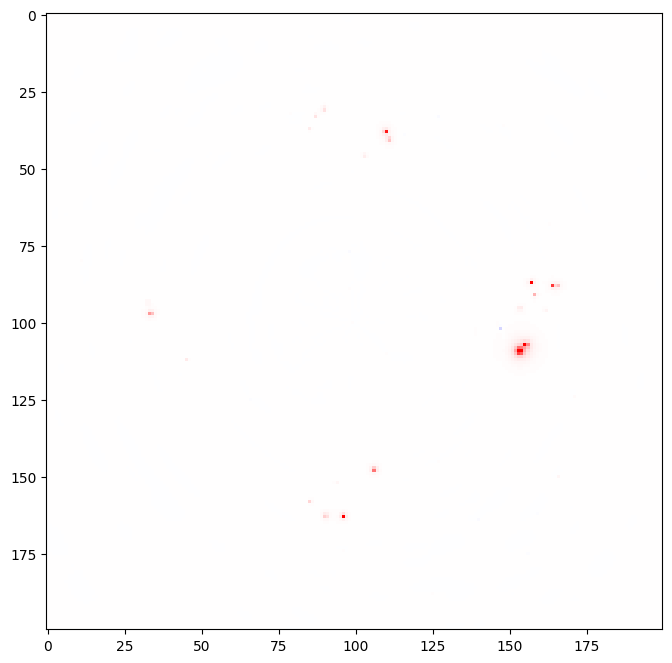

In [13]:
fig = plt.figure(1)
fig.set_size_inches(8,8)

vmin_max = 0.01
cmap = 'bwr'
#plt.scatter(realizationCDM_with_GCs.x, realizationCDM_with_GCs.y)
plt.imshow(kappa_gcs - kappa, vmin=-vmin_max, vmax=vmin_max, cmap=cmap)

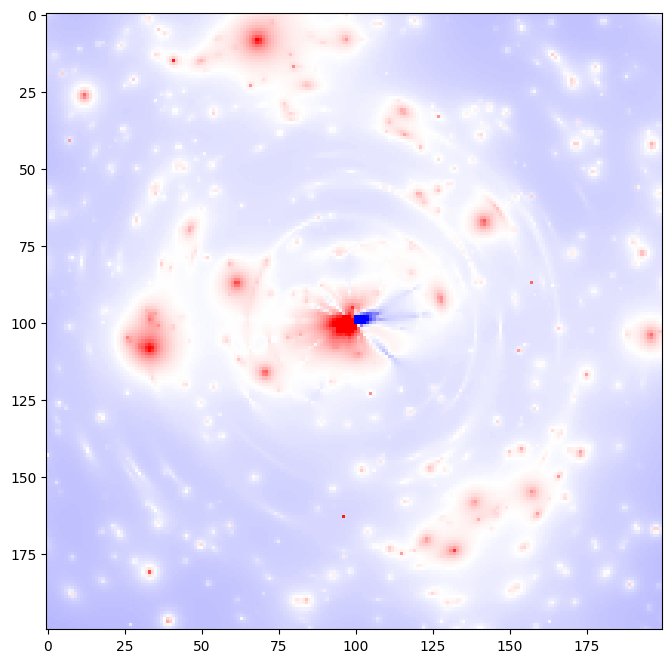

In [8]:
fig = plt.figure(1)
fig.set_size_inches(8,8)

vmin_max = 0.1
cmap = 'bwr'
plt.imshow(kappa_gcs-kappa_macro, vmin=-vmin_max, vmax=vmin_max, cmap=cmap)

In [9]:
real = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.0, 
                     cone_opening_angle_arcsec=cone_opening_angle_arcsec,
                    log_mlow=7.0)
ext = RealizationExtensions(real)
log10_mgc_mean = 5.3
log10_mgc_sigma = 0.5
rendering_radius_arcsec = 1.0 / np.sqrt(np.pi)

realization_GCs = ext.add_globular_clusters(log10_mgc_mean,
                                         log10_mgc_sigma,
                                         rendering_radius_arcsec, 
                                            gamma_mean=3.25,
                                            gamma_sigma=0.25,
                                            gc_size_mean=100,
                                            gc_size_sigma=10,
                                            gc_concentration_mean=50,
                                            gc_concentration_sigma=10,
                                            gc_surface_mass_density=10*10**5.3,
                                        center_x=center_x, center_y=center_y)
masses = np.array([halo.mass for halo in realization_GCs.halos])
print('number of GCs more massive than 10^5: ', np.sum(masses>10**5))
print('number of GCs more massive than 10^6: ', np.sum(masses>10**6))

central_density = []
size = []
masses = []
for gc in realization_GCs.halos:
    rho0, gc_size_kpc, gamma, r_core_kpc = gc.profile_args
    central_density.append(rho0)
    size.append(gc_size_kpc)
    masses.append(gc.mass)

number of GCs more massive than 10^5:  634
number of GCs more massive than 10^6:  76


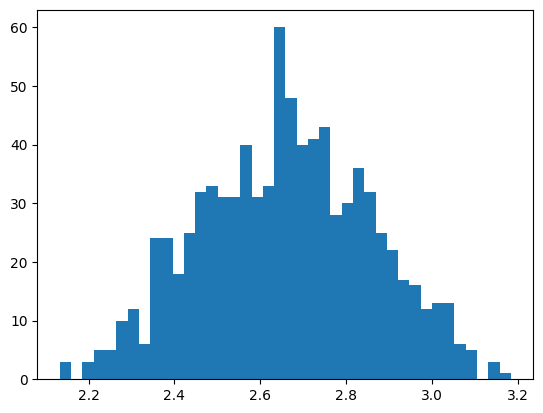

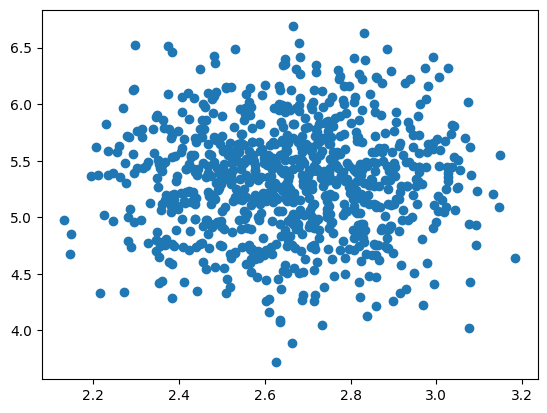

In [10]:
kpc_per_lyr = 0.31 * 1e-3
rho0_msun_per_cubiclyr = np.array(central_density) * kpc_per_lyr ** 3
plt.hist(np.log10(rho0_msun_per_cubiclyr),bins=40); plt.show()

plt.scatter(np.log10(rho0_msun_per_cubiclyr), np.log10(masses))

In [11]:
### Estimate the surface mass density

In [12]:
rhos, rs, r200 = real.lens_cosmo.NFW_params_physical(10**13., 5, 0.5)
R_ein = 8.0 # kpc
R_eff = 2 * R_ein
R = 8 * R_eff
x = R/rs
fx = np.log(1+x) -x/(1+x)
nfw_mass = 4 * np.pi * rs ** 3 * rhos * fx
f = 3.4e-5
M_globular = f * nfw_mass
print(np.log10(M_globular))
area = np.pi * (3 * R_ein) ** 2
print('surface mass density: ', np.log10(M_globular/area))

8.107389702628918
surface mass density:  4.849817346511573


https://arxiv.org/pdf/1809.07831

https://arxiv.org/pdf/1707.02609

https://ui.adsabs.harvard.edu/abs/2014ApJ...787L...5H/abstract

https://arxiv.org/pdf/1602.01105

https://academic.oup.com/mnras/article/419/1/14/998277

In [ ]:
from pyHalo.Halos.lens_cosmo import LensCosmo
from scipy.integrate import quad

In [ ]:
def GCre(mhost=10**13.0):
    return 0.88 + 0.1*np.log10(mhost/10**13) + 1.35

def nfw_mass_enclosed(r, rhos, rs, r200):
    x = r/r200
    return 4 * np.pi * rs ** 3 * rhos * (np.log(1+x) - x/(1+x))

def deVaucouleurs(r, sigma, re, n=4):
    b = 1.9992 * n - 0.3271
    return sigma * np.exp(-b*((r/re)**(1/n)-1))

def gc_system_mass(sigma, re, rmax):
    integrand = lambda x: 2*np.pi*x*deVaucouleurs(x,sigma,re)
    return quad(integrand, 0, rmax)[0]
    
def match_gc_norm(re, rmax, m_gc):
    mgc = gc_system_mass(1.0,re,rmax)
    return m_gc / mgc

In [ ]:
lc = LensCosmo(0.5, 2.0)
m_host = 10**13.3
rhos, rs, r200 = lc.NFW_params_physical(m_host, 6.0, 0.5)

kpc_per_arcsec = 6.2
r_ein = 1. * kpc_per_arcsec
r_eff = 3.0 * r_ein
R = 8 * r_eff
print('rmax: ', R)
print('r200: ', r200)
dm_mass = nfw_mass_enclosed(R, rhos, rs, r200)
print('mass DM: ', np.log10(dm_mass))
mgc = 3.4 * 10**-4 * dm_mass
print('mass GC: ', np.log10(mgc))

In [ ]:
# https://arxiv.org/pdf/1707.02609 find that re_gc ~ 3.5 re_gal
#re_gc = 3.5 * r_eff # kpc
# or with halo mass
re_gc = 0.88 + 0.1 * np.log10(m_host/10**13)+1.35

sigma = match_gc_norm(re_gc, r200, mgc)
R_eval = 0.7 * kpc_per_arcsec
print('sigma', sigma)
print('GC system mass: ', np.log10(gc_system_mass(sigma, re_gc, r200)))
print('GC surface mass density: ', np.log10(deVaucouleurs(R_eval, sigma, re_gc)))

In [ ]:
z_host = 0.5
lc = LensCosmo(z_host, 2.0)
sigma_GC_1 = []
for _ in range(0, 1000):
    m_host = 10**np.random.normal(13.3, 0.3)
    c_host = np.random.uniform(2, 6)
    rhos, rs, r200 = lc.NFW_params_physical(m_host, c_host, z_host)
    kpc_per_arcsec = lc.cosmo.kpc_proper_per_asec(z_host)
    
    r_ein = np.random.uniform(0.7, 1.3)
    r_eff_scale = np.random.uniform(1, 3)
    r_eff = r_eff_scale * r_ein
    R = 8 * r_eff * kpc_per_arcsec
    dm_mass = nfw_mass_enclosed(R, rhos, rs, r200)
    mgc = np.random.uniform(3.4, 6.5) * 10**-4 * dm_mass # from https://arxiv.org/pdf/1602.01105
    re_gc = 0.88 + 0.1 * np.log10(m_host/10**13)+1.35 + np.random.normal(0.0, 0.17) # from https://arxiv.org/pdf/1707.02609
    sigma = match_gc_norm(re_gc, r200, mgc)
    R_eval = r_ein * kpc_per_arcsec
    sigma_GC_1.append(deVaucouleurs(R_eval, sigma, re_gc))
    # print('dm/gc mass', np.log10(dm_mass),np.log10(mgc))
    # print('GC system mass: ', np.log10(gc_system_mass(sigma, re_gc, r200)))
    # print('GC surface mass density: ', np.log10(deVaucouleurs(R_eval, sigma, re_gc)))
    # a=input('continue')
    

In [ ]:
plt.hist(np.log10(sigma_GC_1),bins=25)
print(np.median(np.log10(sigma_GC_1)))

In [ ]:
from pyHalo.Halos.HaloModels.powerlaw import GlobularCluster
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.Halos.HaloModels.TNFW import TNFWFieldHalo
from pyHalo.Halos.tidal_truncation import Multiple_RS
from pyHalo.Halos.concentration import ConcentrationConstant

lens_cosmo = LensCosmo(0.5, 2.0)

truncation_class = Multiple_RS(None, 100)
concentration_class = ConcentrationConstant(None, 16)
tnfw_halo = TNFWFieldHalo(10 ** 8, 
                         0.0, 0.0,None, 0.5, False, lens_cosmo, {}, 
                         truncation_class, concentration_class, 2.0)

mass = 10 ** 5
_x = 0
_y = 0
z = 0.5

gc_size_lightyear = 100
kpc_per_lightyear = 0.000306
gc_size_kpc = gc_size_lightyear * kpc_per_lightyear
args = {'gamma': 2.5, 
       'gc_size_lightyear': gc_size_lightyear, 
       'gc_concentration': 50}
unique_tag = 1
gc = GlobularCluster(mass, 
                    _x, 
                    _y, 
                    z, 
                    lens_cosmo, 
                    args, 
                    unique_tag)

x = np.linspace(0.001, 1.0, 100000) 
r = x * gc_size_kpc

print(np.log10(np.trapz(4*np.pi*r**2 * tnfw_halo.density_profile_3d_lenstronomy(r),r)))
print(np.log10(np.trapz(4*np.pi*r**2 * gc.density_profile_3d_lenstronomy(r),r)))

plt.loglog(r, gc.density_profile_3d_lenstronomy(r))
plt.loglog(r, tnfw_halo.density_profile_3d_lenstronomy(r)); plt.show()


plt.loglog(r*1e3, gc.density_profile_2d_lenstronomy(r)*1e-6); plt.ylim(10, 1e4)